In [2]:
from datetime import datetime, timedelta
from google.cloud import bigquery
import os
import pandas as pd

In [3]:
# follow steps here: https://docs.opensource.observer/docs/integrate/python-notebooks#using-jupyter-on-your-machine
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../gcp_credentials.json'
client = bigquery.Client()

# Get active projects / repos

In [6]:
# change this with your project name in BigQuery
YOUR_PROJECT_NAME = 'opensource-observer'

# you can also do testing with oso-playground
DATASET = 'oso'

# change to 'thank-arb' once it exists
COLLECTION = 'octant-04'

query = f"""
SELECT a.*
FROM `{YOUR_PROJECT_NAME}.{DATASET}.artifacts_by_project_v1` as a
JOIN `{YOUR_PROJECT_NAME}.{DATASET}.projects_by_collection_v1` as pbc 
    ON a.project_id = pbc.project_id
WHERE
    pbc.collection_name = '{COLLECTION}'
    AND a.artifact_source = 'GITHUB'
"""
result = client.query(query)
repos = result.to_dataframe()
repos.tail(3)

,artifact_id,artifact_source_id,artifact_source,artifact_namespace,artifact_name,project_id,project_source,project_namespace,project_name
902,kXY0SyiWbzgaD024IBSw6dfL_gfYUY8TB1XmHTR9l8I=,359957535,GITHUB,1hive,aragon.js,0meRIUEV48cb8Plf7X1knIWJZmcrGA3NY91bcOlUNk8=,OSS_DIRECTORY,oso,1hive
903,6-8ymnq1qeRQU6iXIV9keSPR4PltiTgvx1_fkSDFSfE=,837253936,GITHUB,buidlguidl,nodes.buidlguidl.com,LYjorXBAT3ups7hO6SJ_Uy7fft9PqTeD3Nq2m2El7uM=,OSS_DIRECTORY,oso,buidlguidl
904,VtJFty14X78saoj9Ap5qzPeVnk2hkli-iqMw2ocoPQg=,700553336,GITHUB,buidlguidl,dcbot,LYjorXBAT3ups7hO6SJ_Uy7fft9PqTeD3Nq2m2El7uM=,OSS_DIRECTORY,oso,buidlguidl


In [15]:
artifact_ids = list(repos['artifact_id'].unique())
print(len(artifact_ids))

905


In [8]:
dups = repos.groupby('artifact_id')['project_name'].nunique()
dups[dups>1]

Series([], Name: project_name, dtype: int64)

In [9]:
project_ids = list(repos['project_id'].unique())
len(project_ids)

30

In [10]:
sorted(list(repos['project_name'].unique()))

['1hive',
 'abundanceprotocol',
 'blockscout',
 'buidlguidl',
 'dao-drops-dorgtech',
 'dappnode',
 'desci-latam',
 'ecosynthesisx',
 'ethereum-attestation-service',
 'ethereum-cat-herders',
 'ethstaker',
 'fundingthecommons',
 'givepraise',
 'growthepie',
 'hypercerts',
 'l2beat',
 'nicenode',
 'opensource-observer',
 'pairwise-general-magic',
 'pizzadao',
 'protocol-guild',
 'revoke-cash',
 'rndao',
 'rotki',
 'shutter-network',
 'tor-project',
 'trustful-blockful-io',
 'vyperlang',
 'web3',
 'web3py-ethereum']

# Fetch developer-activity metrics

In [26]:
# turn all the lists of ids into a string we can query in SQL
project_ids_str = "'" + "','".join(project_ids) + "'"
artifact_ids_str = "'" + "','".join(artifact_ids) + "'"
artifact_ids_str[:100]

"'z2Unf_tXgrmzFfUyssYp-aiW0Amxa_PsCja8OsFJa2o=','vCX6FOuu_Gr4D8Y8FuzxqJeQ5QfztSut4Ik959D4Ft0=','KqcvP"

In [27]:
query = f"""
SELECT *
FROM `{YOUR_PROJECT_NAME}.{DATASET}.code_metrics_by_project_v1`
WHERE project_id in ({project_ids_str})
"""
result = client.query(query)
project_metrics = result.to_dataframe()
project_metrics.tail(3)

,project_id,project_source,project_namespace,project_name,display_name,event_source,repository_count,first_commit_date,last_commit_date,star_count,...,contributor_count,contributor_count_6_months,new_contributor_count_6_months,fulltime_developer_average_6_months,active_developer_count_6_months,commit_count_6_months,opened_pull_request_count_6_months,merged_pull_request_count_6_months,opened_issue_count_6_months,closed_issue_count_6_months
27,wV2X-YoRtKKe8l64B030vCC8JLhlFQxaafqSubSsl3w=,OSS_DIRECTORY,oso,givepraise,Praise,GITHUB,14,2021-12-18 11:32:43+00:00,2024-09-10 21:37:17+00:00,43,...,29.0,1.0,0.0,0.097826,1.0,75.0,0.0,0.0,0.0,0.0
28,JFq-iwGwIQrnVt0T7CwaVfsefjXknPPNfe4cABhxzyA=,OSS_DIRECTORY,oso,rndao,RnDAO,GITHUB,13,2022-07-04 13:07:23+00:00,2024-07-17 19:28:02+00:00,5,...,20.0,1.0,0.0,0.000000,1.0,6.0,0.0,0.0,0.0,0.0
29,50Zkidly04WdD8YGpVEbIq0WwTuhI_yuJcWihKUQNo8=,OSS_DIRECTORY,oso,abundanceprotocol,Abundance Protocol,GITHUB,3,2024-08-08 22:46:10+00:00,2024-08-21 21:23:16+00:00,3,...,1.0,1.0,1.0,0.000000,1.0,40.0,2.0,2.0,0.0,0.0


In [24]:
query = f"""
SELECT
  m.metric_name,
  t.artifact_id,
  t.sample_date,
  t.amount
FROM `{YOUR_PROJECT_NAME}.{DATASET}.timeseries_metrics_by_artifact_v0` t
JOIN `{YOUR_PROJECT_NAME}.{DATASET}.metrics_v0` m
  ON t.metric_id = m.metric_id
WHERE t.artifact_id in ({artifact_ids_str})
"""
result = client.query(query)
timeseries_metrics = result.to_dataframe()
timeseries_metrics.tail(3)

,metric_name,artifact_id,sample_date,amount
345375,active_developers,rA_F5iXDICoqGp-8ivBuArVKseye1bSJrnFFsJHQLP4=,2022-02-14 00:00:00+00:00,1
345376,active_developers,7QtkrlGdkljqRs5bq5mJAfqoFz-JEqV1DDexRQEuoEk=,2021-07-21 00:00:00+00:00,1
345377,active_developers,3kbjH0l4B2gIzTl72Zk1qsbfCBXM4bfZ7WnOVirDlyU=,2021-07-21 00:00:00+00:00,1


In [37]:
timeseries_metrics['metric_name'].unique()

array(['fulltime_developers', 'parttime_developers', 'active_developers'],
      dtype=object)

In [53]:
df_repos = pd.merge(left=timeseries_metrics, right=repos, how='inner', on='artifact_id')
df_repos['sample_date'] = pd.to_datetime(df_repos['sample_date']).dt.date
df_repos.tail(3)

,metric_name,artifact_id,sample_date,amount,artifact_source_id,artifact_source,artifact_namespace,artifact_name,project_id,project_source,project_namespace,project_name
345375,active_developers,rA_F5iXDICoqGp-8ivBuArVKseye1bSJrnFFsJHQLP4=,2022-02-14,1,438501086,GITHUB,dappnode,eth2-keymanager-frontend,r1E7lYltpd3pipZ4-yhn6wABCt0mUfRdjxr208MG5fU=,OSS_DIRECTORY,oso,dappnode
345376,active_developers,7QtkrlGdkljqRs5bq5mJAfqoFz-JEqV1DDexRQEuoEk=,2021-07-21,1,379306076,GITHUB,dappnode,dappnodepackage-graph,r1E7lYltpd3pipZ4-yhn6wABCt0mUfRdjxr208MG5fU=,OSS_DIRECTORY,oso,dappnode
345377,active_developers,3kbjH0l4B2gIzTl72Zk1qsbfCBXM4bfZ7WnOVirDlyU=,2021-07-21,1,369676923,GITHUB,1hive,use-wallet,0meRIUEV48cb8Plf7X1knIWJZmcrGA3NY91bcOlUNk8=,OSS_DIRECTORY,oso,1hive


# Display some results

In [55]:
project_snapshot = (
    project_metrics
    .drop(
        columns=['project_id', 'project_source', 'project_namespace', 'event_source']
    )
    .sort_values(
        by='active_developer_count_6_months',
        ascending=False
    )
    .set_index('project_name')
)
project_snapshot

,display_name,repository_count,first_commit_date,last_commit_date,star_count,fork_count,contributor_count,contributor_count_6_months,new_contributor_count_6_months,fulltime_developer_average_6_months,active_developer_count_6_months,commit_count_6_months,opened_pull_request_count_6_months,merged_pull_request_count_6_months,opened_issue_count_6_months,closed_issue_count_6_months
project_name,,,,,,,,,,,,,,,,
l2beat,L2BEAT,12,2021-12-09 11:26:17+00:00,2024-09-10 19:50:46+00:00,858,411,306.0,90.0,59.0,5.804348,58.0,1822.0,1944.0,1835.0,25.0,30.0
opensource-observer,Open Source Observer,11,2023-07-28 01:52:08+00:00,2024-09-10 21:58:47+00:00,142,127,109.0,96.0,86.0,2.570652,52.0,897.0,823.0,765.0,495.0,421.0
blockscout,Blockscout,35,2018-03-08 20:57:01+00:00,2024-09-10 18:45:42+00:00,3914,3094,2429.0,331.0,273.0,2.755435,22.0,2203.0,1058.0,909.0,755.0,749.0
buidlguidl,Buidl Guidl,111,2018-08-14 00:15:49+00:00,2024-09-10 14:41:02+00:00,12718,8733,878.0,150.0,99.0,2.826087,20.0,1606.0,858.0,717.0,318.0,327.0
dappnode,DAppNode,254,2018-02-27 19:36:04+00:00,2024-09-10 16:12:06+00:00,1092,661,386.0,53.0,22.0,1.826087,19.0,1109.0,1104.0,607.0,123.0,116.0
rotki,rotki,28,2018-12-15 14:32:31+00:00,2024-09-10 21:24:41+00:00,2824,603,513.0,58.0,36.0,3.353261,9.0,1846.0,1038.0,1000.0,119.0,123.0
shutter-network,Shutter Network,37,2021-04-12 09:00:15+00:00,2024-09-10 14:19:32+00:00,102,39,26.0,11.0,4.0,0.108696,8.0,374.0,85.0,81.0,67.0,36.0
ethstaker,EthStaker,14,2020-10-14 02:41:20+00:00,2024-09-10 15:58:39+00:00,859,419,240.0,53.0,33.0,1.228261,7.0,649.0,261.0,240.0,82.0,62.0
web3,web3.js,9,2021-04-29 23:41:15+00:00,2024-09-09 14:20:33+00:00,19180,4957,2333.0,100.0,82.0,0.000000,7.0,147.0,208.0,127.0,148.0,157.0


/opt/anaconda3/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



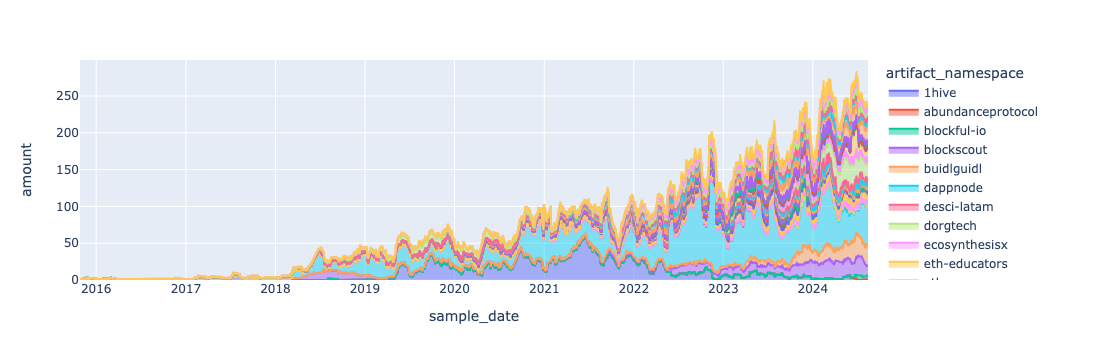

In [56]:
import plotly.express as px

gby = (
    df_repos[df_repos.metric_name == 'active_developers']
    .groupby(['artifact_namespace', 'sample_date'])['amount'].sum()
    .reset_index()
)

px.area(
    data_frame=gby,
    x='sample_date',
    y='amount',
    color='artifact_namespace'
)

# Export markdown tables

In [57]:
(
    project_snapshot[['display_name', 'star_count', 'contributor_count']]
    .sort_values(by='star_count', ascending=False)
    .to_markdown('sample_export.md')
)